          Cobra Kai          Lupin          12 Monkeys          Sherlock  \
0              Lost      Jack Ryan           The Flash   Game of thrones   
1     Sex Education      Dr. House             Kingdom  The Walking Dead   
2             Ozark  Sex Education         Constantine          Preacher   
3            Naruto            NaN                 NaN               NaN   
4     Sex Education            NaN                 NaN               NaN   
...             ...            ...                 ...               ...   
9684      One Piece  The Blacklist  Two and a half men             Lupin   
9685      One Piece      Mr. Robot          Succession             Ozark   
9686      Daredevil       Atypical               Heros               NaN   
9687       Absentia   The Newsroom        The Alienist               NaN   
9688       Atypical            NaN                 NaN               NaN   

          Unnamed: 4             Unnamed: 5           Unnamed: 6 Unnamed: 7  \
0     Ho

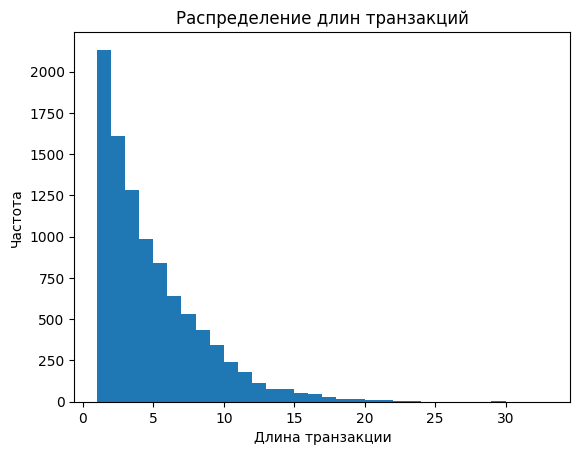

{'The Alienist', 'Rome', "The Handmaid's Tale", 'Elite', 'Sacred Games', 'Suits', 'The Umbrella Academy', 'Loki', 'Preacher', 'The Wire', 'Supergirl', 'Inside Job', 'Startup', 'Nine Perfect Strangers', 'Altered Carbon', 'One Piece', 'The Blacklist', 'Madmen', 'The Wheel of Time', 'Watchmen', 'Sopranos', 'Friends', 'Game of thrones', 'The Boys', 'Sex Education', "Grey's Anatomy", 'Outer Banks', 'Lucifer', 'The man in the high castle', 'Sense 8', 'You', 'Dexter', 'Good Omens', 'The Witcher', 'Ozark', 'The 100', 'Brooklyn Nine Nine', 'Better Call Saul', 'Black Clover', 'Breaking Bad', 'Atypical', 'Kingdom', 'Iron Fist', 'Perception', 'The IT Crowd', 'Upload', 'Doctor Who', 'The Good Doctor', 'Fringe', 'Only Murders in the building', 'Mr. Robot', 'The Vampire Diaries', 'Big Little Lies', 'Daredevil', 'Cobra Kai', 'Person of Interest', 'Sons of Anarchy', 'Young Sheldon', 'Gotham', 'Lupin', 'Alice in Borderland', 'The Originals', 'Haven', 'The Newsroom', "The Queen's Gambit", 'Prison Break',

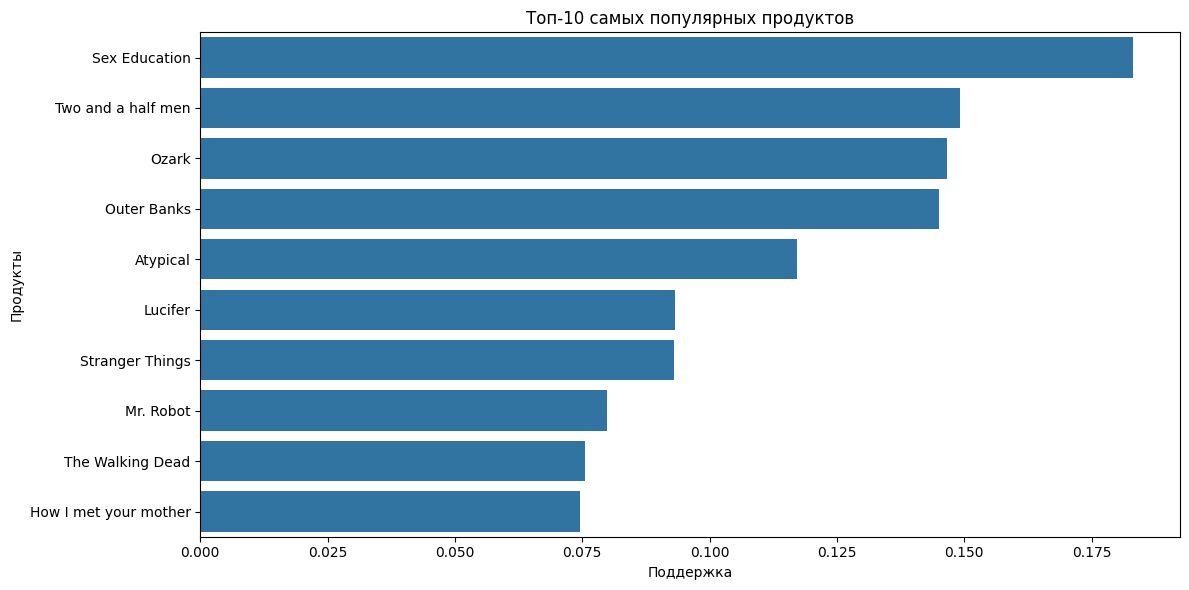

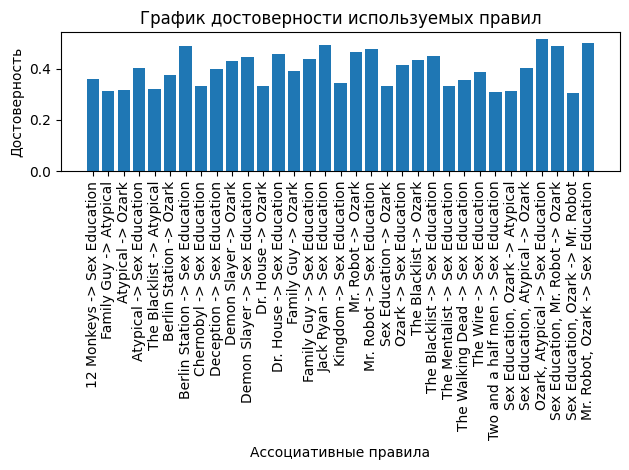

C:\Users\origi\AppData\Local\Temp\ipykernel_19212\900566233.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


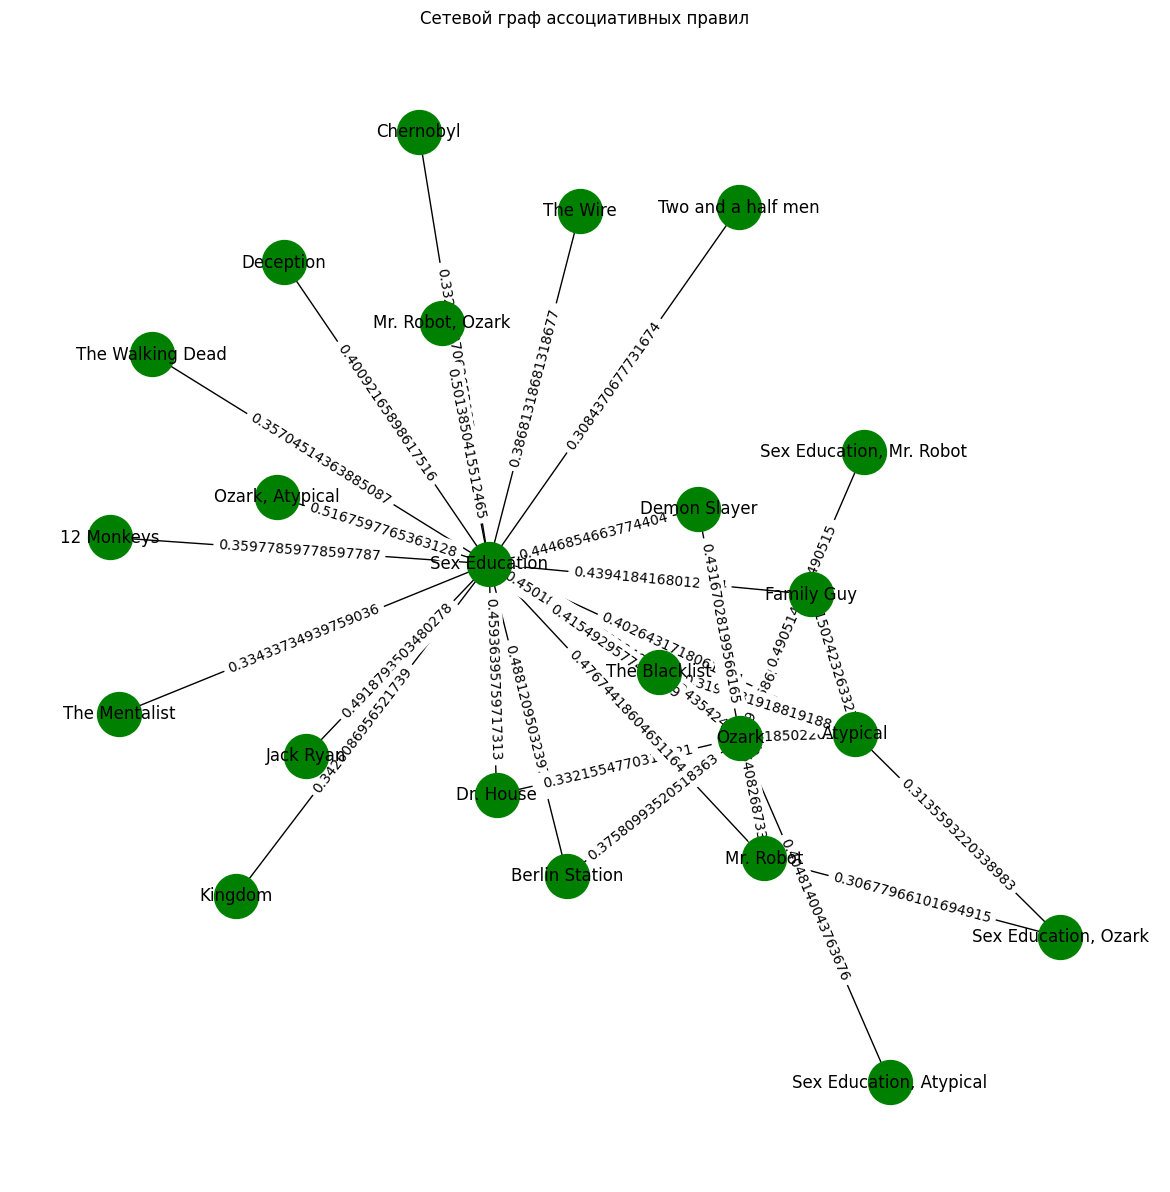

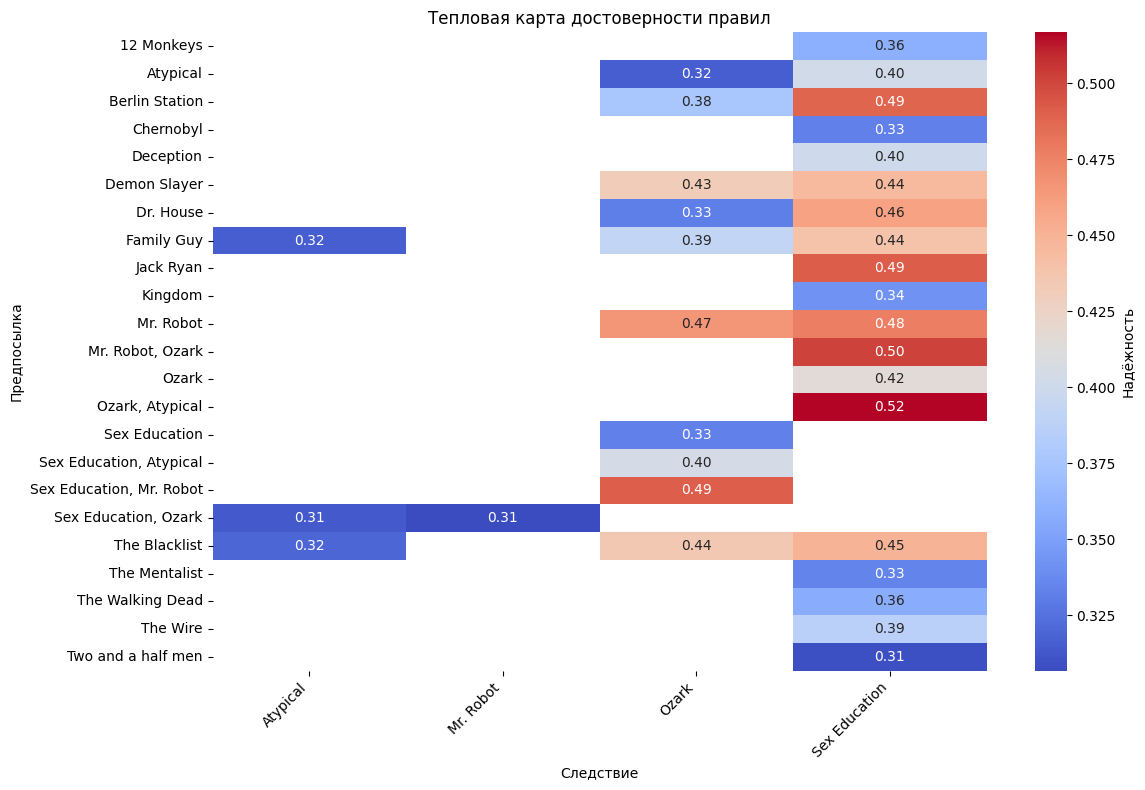

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx


# Загрузка данных
all_data = pd.read_csv('TV_Shows.csv')
print(all_data)

# Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

# Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem, str)]
           for row in np_data]

# Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

# Алгоритм FPG
# df1 = fpgrowth(data, min_support=0.02, use_colnames=True)
# print(df1)
# rules = association_rules(df1, metric="confidence", min_threshold=0.3)
# print(rules)

# # Алгоритм Apriori
df1 = apriori(data, min_support=0.016, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

# Поддержка
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}"
                for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Визуализация ассоциативных правил в виде графа
G = nx.Graph()

for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'],
               weight=row['confidence'])

num_nodes = len(G.nodes())
fig_size = max(8, min(15, num_nodes * 0.5))

plt.figure(figsize=(fig_size, fig_size))

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='green',
        font_size=12)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

heatmap_data = rules.copy()
heatmap_data['support'] = rules.apply(
    lambda row: df1[df1['itemsets'] == row['antecedents']]['support'].values[0], axis=1
)
heatmap_data['confidence'] = rules['confidence']

heatmap_matrix = heatmap_data.pivot(index='antecedents', columns='consequents', values='confidence')

sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Надёжность'})
plt.title('Тепловая карта достоверности правил')
plt.xlabel('Следствие')
plt.ylabel('Предпосылка')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 2. Описание данных из датасета

Был загружен датасет "TV_Shows.csv", содержащий информацию о транзакциях телешоу. Датасет состоит из 9689 строк и 32 столбцов. Каждая строка представляет собой транзакцию (набор телешоу, которые пользователь смотрит вместе).

Также был построен гистограммный график распределения длин транзакций, который показывает, что большинство транзакций имеют небольшую длину (1-5 элементов). С увеличением длины транзакции частота резко уменьшается.

Помимо этого, был выявлен список уникальных телешоу в датасете (всего 175 различных наименований).

На основе проведённого первичного анализа можно сделать следующие выводы:
1. Датасет содержит разреженные данные с преобладанием коротких транзакций, что типично для поведения просмотра телешоу.

2. Наличие 175 уникальных товаров и разнообразных транзакций создает хорошую основу для выявления значимых ассоциативных правил.

3. Данные успешно преобразованы в формат, пригодный для применения алгоритмов Apriori и FPGrowth в следующих этапах работы.

4. Распределение демонстрирует резкий спад частоты с увеличением длины транзакции. Большинство пользователей предпочитают смотреть небольшое количество шоу совместно (1-3 шоу), что отражает реальные паттерны потребления контента. Это важно учитывать при выборе параметров поддержки для алгоритмов ассоциативных правил.

# 3. Алгоритм Apriori

Был проведен анализ ассоциативных правил для транзакционных данных о просмотре телесериалов с использованием алгоритма Apriori. Исходные параметры (по варианту) - min_support (0.02) и min_confidence (0.3). Вывод следующий:

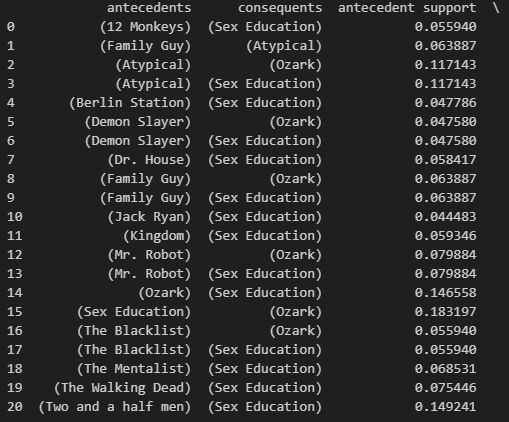
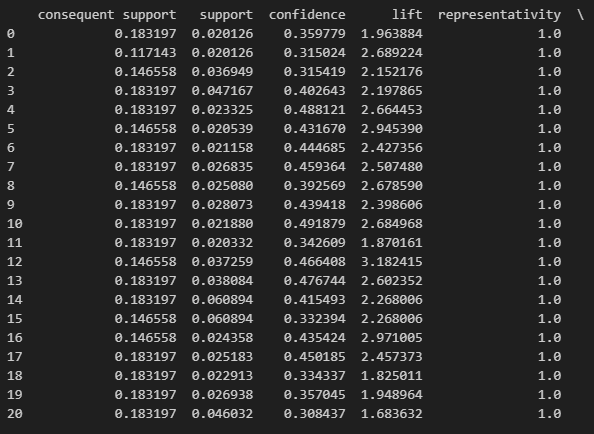

Полезные правила - это правила со значением лифта больше 2 (т.е. связь гораздо сильнее случайного совпадения), которые раскрывают нетривиальные взаимосвязи.
На основе проведенного анализа можно выделить следующие полезные правила:
1) (Mr. Robot) -> (Ozark): lift = 3.18, support = 0.037, confidence = 0.466. Показатели говорят о том, что зрители "Мистера Робота" в 3.18 раза чаще среднего смотрят "Ozark". Это самая сильная находка в данных. Людям, которым нравится "Мистер Робот", также нравится смотреть "Ozark".

2) (Demon Slayer) -> (Ozark): lift = 2.95, support = 0.021. Показатели говорят о том, что те, кто смотрит "Demon Slayer" в 2.95 раза чаще среднего смотрят "Ozark". Также довольно сильная связь.
3) (The Blacklist) -> (Ozark): lift = 2.97, support = 0.024. Показатели говорят о том, что зрители "The Blacklist" в 2.68 раза чаще среднего смотрят "Ozark", сильная связь.
4) (Family Guy) -> (Ozark): ligt = 2.68, support = 0.025. Также наблюдается устойчивая закономерность - те, кто посмотрел "Family Guy", в 2.68 раза чаще среднего смотрят "Ozark"
5) (Jack Ryan) -> (Sex Education): lift = 2.68, support = 0.022, confidence = 0.492. Зрители "Jack Ryan" в 2.68 раза чаще среднего смотрят "Sex Education".
6) (Atypical) -> (Sex Education): lift = 2.19, support = 0.047167, confidence = 0.403. Т.е. зрители "Atypical" в 2.19 раза чаще среднего смотрят и "Sex Education". 
7) 1) (Ozark) -> (Sex Education): support = 0.060894, confidence = 0.415, lift = 2.27
   2) (Sex Education) -> (Ozark): support = 0.060894, confidence = 0.332, lift = 2.27
   Т.е. видна сильная двусторонняя связь.

Тривиальными правилами будем считать правила со значением лифта меньше 2. В рамках рассматриваемого набора данных были выявлены следующие тривиальные правила:
1) (Two and a Half Men) -> (Sex Education): lift = 1.68, confidence = 0.308, support = 0.046;

2) (Kingdom) -> (Sex Education): lift = 1.87, confidence = 0.343, support = 0.020;
3) (The Mentalist) -> (Sex Education): lift = 1.825, confidence = 0.334, support = 0.022;
4) (12 Monkeys) -> (Sex Education): lift = 1.964, confidence = 0.360, support = 0.020;
5) (Walking Dead) -> (Sex Education): lift = 1.948, confidence = 0.357, support = 0.026;
Эти правила показывают относительно ложную корреляцию по факту того, что Sex Education сам по себе слишком массовый - оттого ложных корреляций много.

Таким образом, примерная градация достоверности и лифта:
- Lift > 3.0 — очень сильная связь, почти точно не случайность

- Lift 2.5–3.0 — сильная связь, высокое доверие
- Lift 2.0–2.5 — средняя, но полезная
- Lift < 2.0 — связь слабая или почти тривиальная
- Confidence > 0.45 — правило надёжно срабатывает
- Confidence 0.30–0.45 — умеренная уверенность
- Confidence < 0.30 — почти бесполезное

После увеличения порога минимальной поддержки min_support с 0.02 до 0.03 и минимального порога метрики min_threshold (confidence) с 0.3 до 0.4 наблюдается заметное изменение в структуре и объёме получаемых ассоциативных правил.
Осталось всего 4 правила и все из них имеют support в пределах от 0.037 до 0.06, т.е. встречаются минимум у 3–6% пользователей:

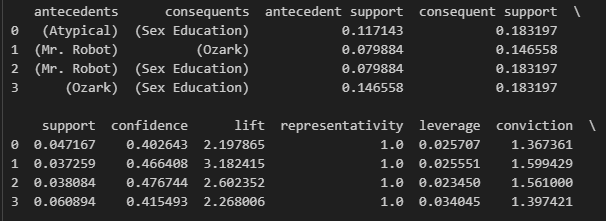

Это логично — более редкие сочетания отсеклись из-за повышения min_support.

Lift стал довольно высоким — 2.19–3.18.
Это означает, что оставшиеся правила действительно сильные (взаимосвязь в 2–3 раза выше случайной).
При более низких порогах часто остаются слабые лифты (1.1–1.4) — их теперь нет.

Таким образом, повышение параметров приводит к уменьшению числа правил, но увеличивает их «качество»: сильные связи остаются, а слабые и нерелевантные — отсеиваются.




# 4. Алгоритм FPG



В качестве результата применения алгоритма FPG для выявления ассоциативных правил получаем следующие правила:
1)	12 Monkeys -> Sex Education: support=0.020126, confidence=0.3598, lift=1.964 => Тривиальное

2)	Jack Ryan -> Sex Education: support=0.021880, confidence=0.4919, lift=2.685 => Полезное
3)	The Walking Dead -> Sex Education: support=0.026938, confidence=0.3570, lift=1.949 => Тривиальное
4)	Kingdom -> Sex Education: support=0.020332, confidence=0.3426, lift=1.870 => Тривиальное
5)	Dr. House -> Sex Education: support=0.026835, confidence=0.4594, lift=2.507 => Полезное
6)	Atypical -> Sex Education: support=0.047167, confidence=0.4026, lift=2.198 => Полезное
7)	Atypical -> Ozark: support=0.036949, confidence=0.3154, lift=2.152 => Полезное
8)	Two and a half men -> Sex Education: support=0.046032, confidence=0.3084, lift=1.684 => Тривиальное
9)	The Blacklist -> Sex Education: support=0.025183, confidence=0.4502, lift=2.457 => Полезное
10)	The Blacklist -> Ozark: support=0.024358, confidence=0.4354, lift=2.971 => Полезное
11)	Berlin Station -> Sex Education: support=0.023325, confidence=0.4881, lift=2.664 => Полезное
12)	Family Guy -> Sex Education: support=0.028073, confidence=0.4394, lift=2.399 => Полезное
13)	Family Guy -> Ozark: support=0.025080, confidence=0.3926, lift=2.679 => Полезное
14)	Family Guy -> Atypical: support=0.020126, confidence=0.3150, lift=2.689 => Тривиальное
15)	Ozark -> Sex Education: support=0.060894, confidence=0.4155, lift=2.268 => Полезное
16)	Sex Education -> Ozark: support=0.060894, confidence=0.3324, lift=2.268 => Полезное
17)	Demon Slayer -> Ozark: support=0.020539, confidence=0.4317, lift=2.945 => Тривиальное
18)	Demon Slayer -> Sex Education: support=0.021158, confidence=0.4447, lift=2.427 => Тривиальное
19)	Mr. Robot -> Ozark: support=0.037259, confidence=0.4664, lift=3.182 => Полезное
20)	Mr. Robot -> Sex Education: support=0.038084, confidence=0.4767, lift=2.602 => Полезное
21) The Mentalist -> Sex Education: support=0.022913, confidence=0.3343, lift=1.825 => Тривиальное


# 5. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

При начальных параметрах min_support=0.02 и min_threshold=0.3 мы имеем следующие ассоциативные правила:

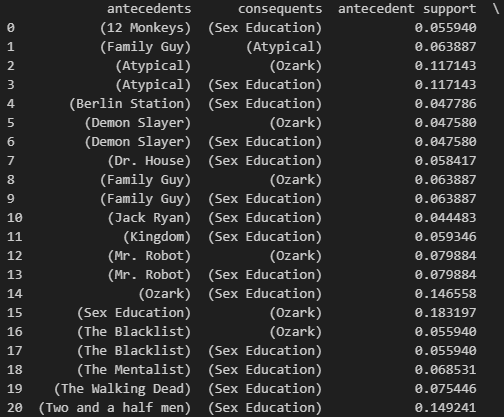
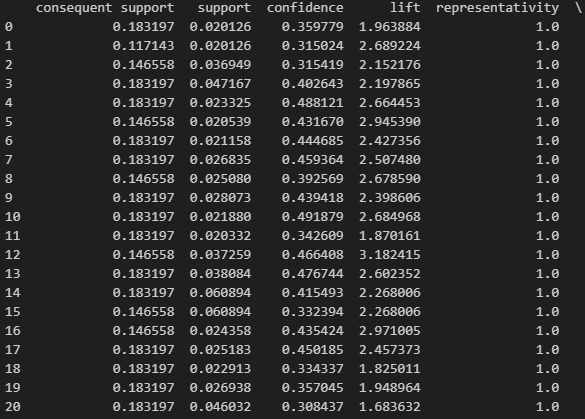

Были проведены следующие эксперименты с изменением параметров:
1) min_support=0.05 и min_threshold=0.3 (ищем "Хиты" - получим только те правила, где все части правила - очень популярные сериалы\фильмы):

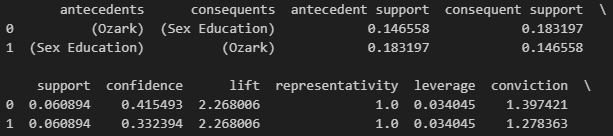

В итоге осталось лишь два взаимосвязанных правила, состоящих из самых популярных кинокартин, так ещё и частовстречающихся вместе!

2) Теперь рассмотрим нишевые кинокартины - min_support=0.015 и min_threshold=0.5:

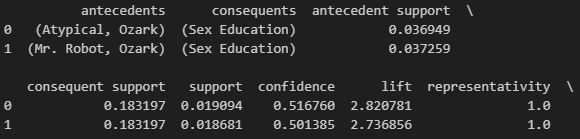

Эксперимент с низким уровнем поддержки (min_support=0.015) и высоким порогом достоверности (min_threshold=0.5) выявил две очень сильные, но не массовые ассоциации. Это не случайные совпадения, а устойчивые поведенческие паттерны узких групп.

3) Теперь сделаем min_support=0.01, но ещё выше сделаем min_threshold - до 0.6:

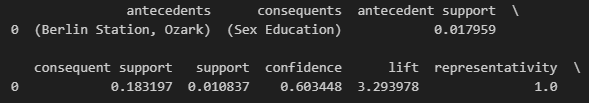

Эксперимент выявил одну-единственную ассоциацию, которая проходит через сверхжесткие фильтры: низкую частоту и сверхвысокую достоверность. Это не просто закономерность, это — предпочтения очень узкой, но предельно лояльной группы зрителей.
Т.е. среди зрителей, которые посмотрели оба сериала "Berlin Station" и "Ozark", более 60% (60.3%) также посмотрели "Sex Education".

Таким образом, на основе проведённых экспериментов, можно сделать следующие выводы о влиянии параметров min_support и min_threshold на формирование ассоциативных правил:
1) Параметр min_support выступает в роли «фильтра массовости», определяя, какие товары и транзакции вообще попадают в поле зрения алгоритма. Высокое значение min_support (например, 0.05) фокусирует анализ на самых популярных продуктах, выявляя общие, широко распространённые тренды. Это даёт картину поведения усреднённого, массового пользователя. С другой стороны, низкий min_support (например, 0.01) открывает доступ к анализу редких товаров, позволяя обнаруживать уникальные, скрытые паттерны. Однако, резко возрастает общее количество кандидатов в правила, что может привести к комбинаторному взрыву и появлению статистически незначимых или случайных ассоциаций. 

2) Параметр min_threshold, в свою очередь, является «фильтром надёжности», контролирующим прогнозную силу найденных правил. Он работает с метрикой "достоверность", отсекая слабые связи и оставляя только те, в которых можно быть уверенным. Высокий min_threshold (например, 0.6) гарантирует, что оставшиеся правила будут обладать исключительной прогнозной силой — если пользователь купил товар A, то с очень высокой вероятностью он купит и товар B. Низкий же порог (например, 0.2) позволяет увидеть всю палитру возможных связей, включая слабые и умеренные, что полезно для формирования полной картины, но чревато наличием в результатах большого количества малополезных ассоциаций.



# 6. Анализ визуализации ассоциативных правил в виде графа и формирование собственного способа визуализации ассоциативных правил и метрик

Рассмотрим граф ассоциативных правил для min_support=0.12 и min_threshold=0.5:

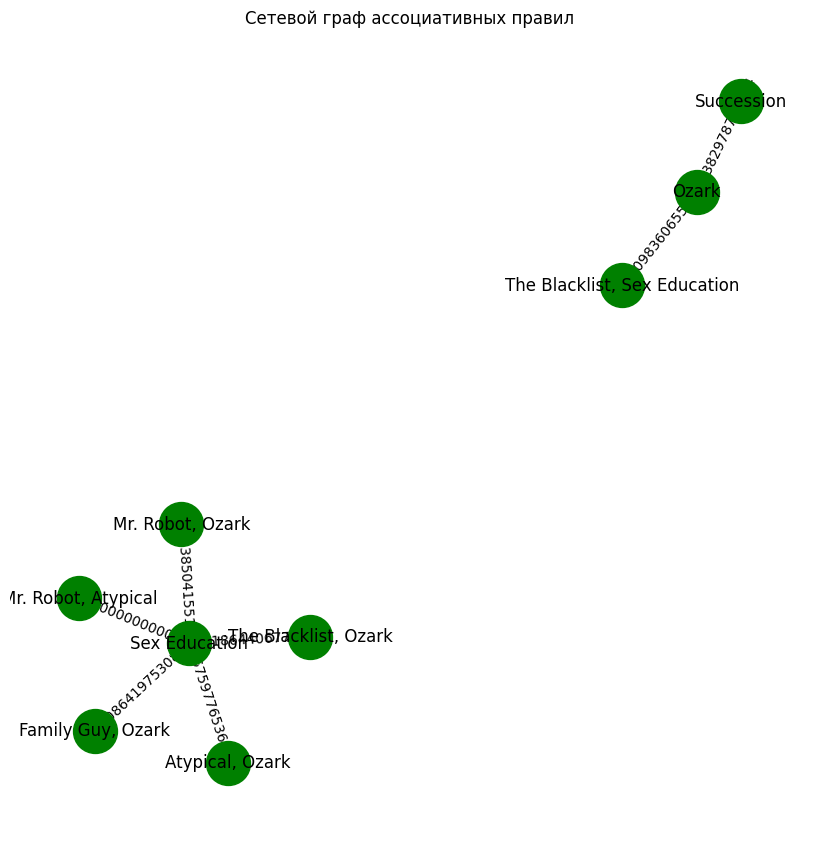

Вершины содержат в себе название сериала или комбинации сериалов.
Рёбра изображают ассоциативные правила между сериалами.
На рёбрах графа подписана метрика confidence (достоверность) для пары вершин.

Выделим следующие ключевые закономерности:
К Sex Education и Ozark тянутся большинство правил. Это указывает на то, что эти сериалы чаще всего встречаются в сочетаниях и формируют сильные ассоциации с другими сериалами.
Граф разбивается на два кластера:
1) Кластер Sex Education: соединён с Atypical, Mr. Robot, Family Guy, The Blacklist

2) Кластер Ozark: соединён с The Blacklist и Succession

Т.е. граф можно также использовать для построения уже визуализированной рекомендательной системы.

В качестве альтернативы (как средства визуализации) можно предложить формирование heatmap по сформированным ассоциативным правилам:

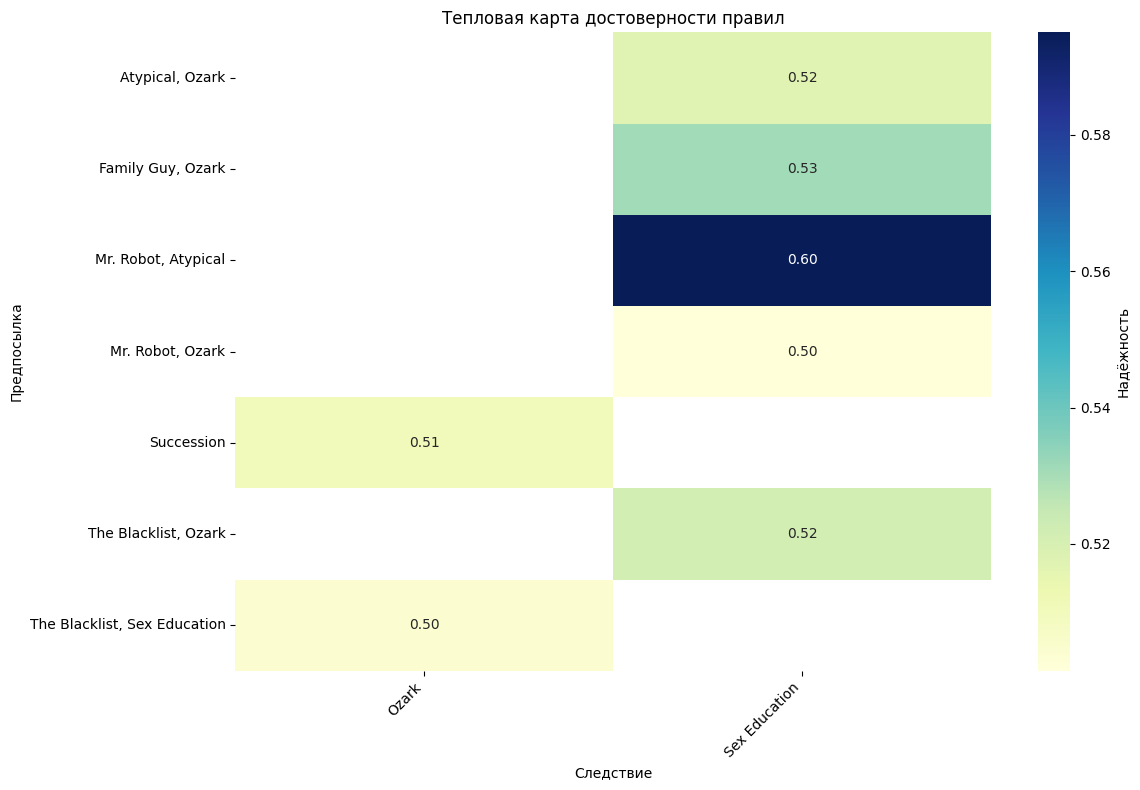

Где каждая клетка - это правило типа "А -> B", в котором A - это предпосылка, а B - это последствие. Цвет показывает достоверность правила (есть шкала измерений для удобства) и сразу видно, какие пары кинокартин связаны сильной ассоциацией (по метрике достоверности).